In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
import scipy.stats as stats
import mpl_toolkits
from matplotlib import cm
import statsmodels.stats.api as sms
import math

%matplotlib inline

from IPython.display import HTML

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Producing graph for sensitivity of frequency parameters over multiple wavelengths

In [49]:
def x(a, t):
    return (1/math.sqrt(a))*math.sin(math.sqrt(a)*t) - (1/math.sqrt(a))*math.cos(math.sqrt(a)*t)
    

def y(a, t):
    return math.cos(math.sqrt(a)*t) + math.sin(math.sqrt(a)*t)

In [50]:
t = np.linspace(0,20, 101)
a = 1
delta_a = a + 0.2

x_t = [x(a,time) for time in t]
y_t = [y(a,time) for time in t]
delta_y_t = [y(delta_a,time) for time in t]

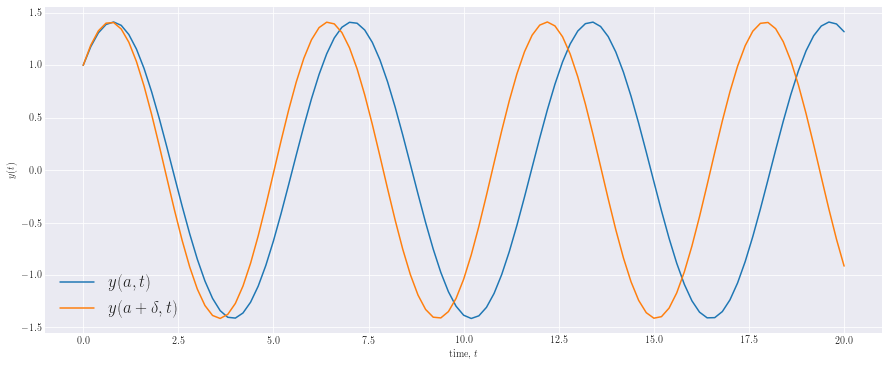

In [51]:
plt.figure(figsize=(15,6))
plt.ylabel('$y(t)$')
plt.xlabel('time, $t$')
plt.plot(t, y_t)
plt.plot(t, delta_y_t)
plt.legend(['$y(a, t)$', '$y(a + \delta, t)$'], prop={'size': 17})
plt.show()

## M-H Multimodal Difficulty

In [5]:
theta = np.linspace(-4,4, 201)


def posterior(theta):
    return 0.4*norm.pdf(theta, -2, 0.2)+ 0.6*norm.pdf(theta, 2.2, 0.4)

pdf_theta = posterior(theta)

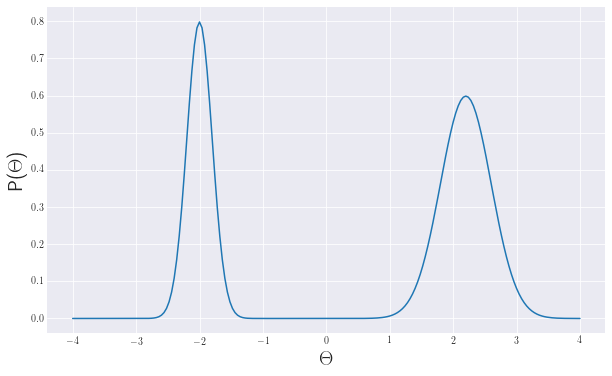

In [29]:
import matplotlib.style as style

plt.figure(figsize = ([10,6]))
style.use('seaborn-darkgrid')
plt.plot(theta, pdf_theta)
plt.xlabel('$\Theta$', fontsize = 20)
plt.ylabel('P($\Theta$)', fontsize = 20)
plt.savefig('multmodal_diff_pdf.pdf', bbox_inches = 'tight')

In [10]:
# Proposal Distribution


sd = 0.5

def q_dist(theta, sd):
    # Gaussian proposal
    return stats.norm.rvs(theta, sd)


def test_for_cov_estimation(acceptance_log):
    # If the acceptance ratio falls below 0.15 or above 0.35, we will re-estimate the covaraiance matrix.
    ratio = sum(acceptance_log) / len(acceptance_log)
    if ratio < 0.15:
        return True, ratio
    elif ratio > 0.35:
        return True, ratio
    else: 
        return False, ratio
    
    
def estimate_var(samples):
    # Estimates the variance entry for one parameter
    samp_mean = np.mean(samples)
    var_estimate = 0
    for entry in samples:
        var_estimate = var_estimate + (entry - samp_mean)**2
    var_estimate = (1/(len(samples)-1))*var_estimate
    return var_estimate


def within(df_of_samples):
    """
    Calculates within-chain variance.
    """
    s = []
    for col in list(df_of_samples):
        s.append(np.var(df_of_samples[col]))
    W = np.mean(s)
    return W


def between(df_of_samples):
    """
    Calculates between-chain variance.
    """
    mu = []
    for col in list(df_of_samples):
        mu.append(np.mean(df_of_samples[col]))
    mu_overall = np.mean(mu)
    m = len(list(df_of_samples))
    n = len(df_of_samples[0])
    B = (n/(m- 1.0)) * np.sum((mu - mu_overall)**2)
    return B


def R_hat(samples):
    """
    Calculates r-hat = sqrt(((n - 1)/n * W + (1/n) * B)/W) as per "Bayesian
    data analysis", 3rd edition, Gelman et al., 2014.
    """
    W = within(samples)
    B = between(samples)
    n = len(samples[0])
    return np.sqrt((W + (1.0 / n) * (B - W)) / W)

In [11]:
def mh_algorithm(theta_0, n, m, q_dist, sd):
    """
    Metropolis-Hastings algorithm, based on Information Theory, Inference, and
    Learning Algorithms, MacKay 2003.
    
    ------------------------------------------------------------------------
    
    Inputs
    
    theta_0 - set of starting starting for chains, must be length m
    n - duration to run the chain before checking R hat diagnostic
    m - number of chains
    q_dist - proposal distribution
    
    ------------------------------------------------------------------------
    
    Returns
    
    set_of_trace - dictionary of the m chains
    acceptance_hist - df of the history of proposed state acceptance
    ratio_hist - df of the acceptance ratio
    
    
    """
    iter_loop = 0
    acceptance_hist = []
    ratio_hist = []
    set_of_trace = {}
    for i in range(m):
        trace = pd.DataFrame(columns = ["a"])
        trace = trace.append(pd.DataFrame([theta_0[i]], columns = ["a"]))
        loop_num = 1
        theta = theta_0[i]
        while loop_num < n:
            # Propose new step
            y = norm.rvs(theta, sd)
            p_x = posterior(theta)
            p_y = posterior(y)
            alpha = min(p_y / p_x, 1)
            # Generate random number to decide if we accept proposal
            rand = np.random.uniform(0,1)
            if rand > 1- alpha:
                theta_new = y
                acceptance_hist.append(1)
            else:
                theta_new = theta
                acceptance_hist.append(0)
            theta = theta_new
            
            trace = trace.append(pd.DataFrame([theta], columns = ["a"]))
                
            loop_num = loop_num + 1
        trace = trace.reset_index()
        trace = trace.drop(["index"], axis=1)
        set_of_trace[i] = trace
    # Calculate and print R hat
    k_set_of_trace = {}
    r_set_of_trace = {}
    for i in range(len(set_of_trace)):
        r_set_of_trace[i] = set_of_trace[i]['a']
    r_hat_r = R_hat(r_set_of_trace)
    print("----------------------------------")
    print("R hat statistic for r :" + str(r_hat_r))
    print("----------------------------------")
    return set_of_trace, pd.DataFrame(acceptance_hist), pd.DataFrame(ratio_hist)

In [12]:
theta_0 = [0, -3]

In [13]:
# Running our M-H chain with a proposal distribution with a standard deviation of 0.5.

set_of_trace, acceptance_hist, ratio_hist = mh_algorithm(theta_0, 3000, 2, q_dist, 0.5)

----------------------------------
R hat statistic for r :9.61338919127
----------------------------------


In [14]:
# Running our M-H chain with a proposal distribution with a standard deviation of 5.

set_of_trace_2, acceptance_hist_2, ratio_hist_2 = mh_algorithm(theta_0, 3000, 2, q_dist, 5)

----------------------------------
R hat statistic for r :1.00400864075
----------------------------------


### Constructing KDE for both values of sd

In [15]:
kernel_1 = stats.gaussian_kde(set_of_trace[0]['a'].tolist(), bw_method = 0.3)

In [16]:
grid_1 = np.linspace(-5,5, 101)
kde_1= kernel_1(grid_1)

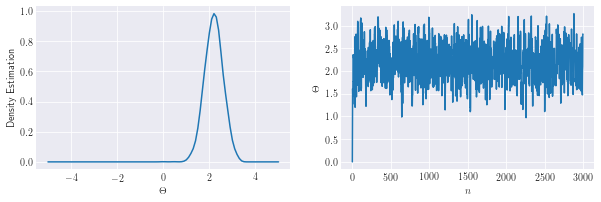

In [17]:
f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

kde_1_df = pd.DataFrame(index = grid_1)
kde_1_df['kde'] = kde_1
ax.plot(kde_1_df)
ax.set_ylabel('Density Estimation')
ax.set_xlabel('$\Theta$')

ax2.plot(set_of_trace[0])
ax2.set_xlabel('$n$')
ax2.set_ylabel('$\Theta$')
plt.show()

In [18]:
kernel_2 = stats.gaussian_kde(set_of_trace_2[0]['a'].tolist(), bw_method = 0.3)

In [19]:
grid_2 = np.linspace(-5,5, 101)
kde_2= kernel_2(grid_2)

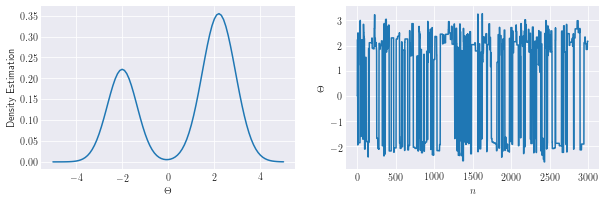

In [20]:
f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

kde_2_df = pd.DataFrame(index = grid_2)
kde_2_df['kde'] = kde_2
ax.plot(kde_2_df)
ax.set_ylabel('Density Estimation')
ax.set_xlabel('$\Theta$')

ax2.plot(set_of_trace_2[0])
ax2.set_xlabel('$n$')
ax2.set_ylabel('$\Theta$')
plt.show()

### Creating figures to save

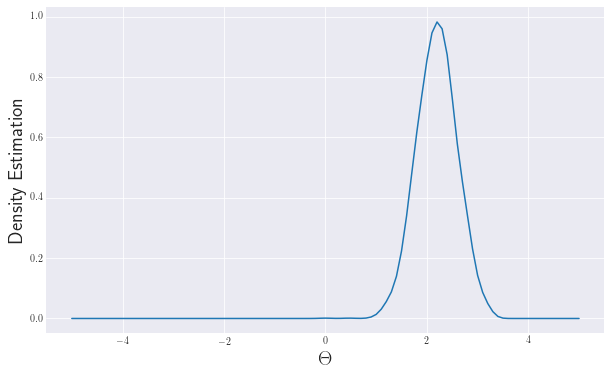

In [30]:
f = plt.figure(figsize=(10,6))

ax = f.add_subplot(111)

kde_1_df = pd.DataFrame(index = grid_1)
kde_1_df['kde'] = kde_1
ax.plot(kde_1_df)
ax.set_ylabel('Density Estimation', fontsize = 20)
ax.set_xlabel('$\Theta$', fontsize = 20)
plt.savefig('multi_mod_1_den.pdf', bbox_inches = 'tight')

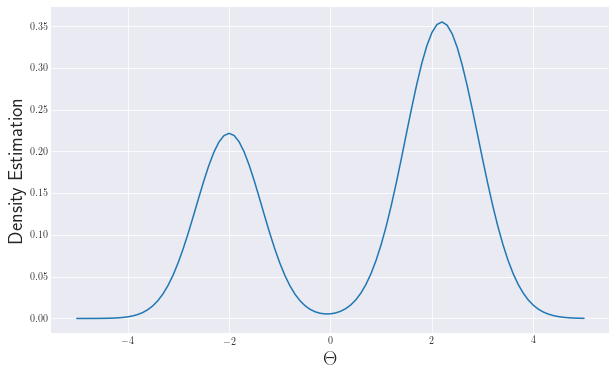

In [31]:
f = plt.figure(figsize=(10,6))

ax = f.add_subplot(111)

kde_2_df = pd.DataFrame(index = grid_2)
kde_2_df['kde'] = kde_2
ax.plot(kde_2_df)
ax.set_ylabel('Density Estimation', fontsize = 20)
ax.set_xlabel('$\Theta$', fontsize = 20)
plt.savefig('multi_mod_2_den.pdf', bbox_inches = 'tight')

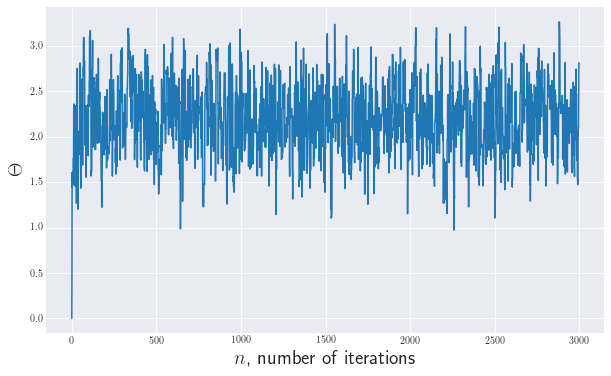

In [36]:
f = plt.figure(figsize=(10,6))

ax2 = f.add_subplot(111)

ax2.plot(set_of_trace[0])
ax2.set_xlabel('$n$, number of iterations', fontsize = 20)
ax2.set_ylabel('$\Theta$', fontsize = 20)
plt.savefig('multimod_1_trace.pdf', bbox_inches = 'tight')

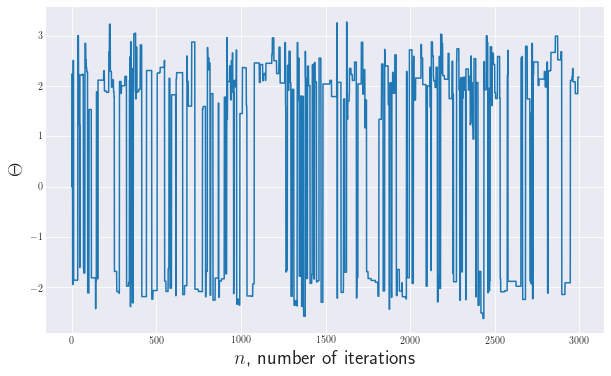

In [37]:
f = plt.figure(figsize=(10,6))

ax2 = f.add_subplot(111)

ax2.plot(set_of_trace_2[0])
ax2.set_xlabel('$n$, number of iterations', fontsize = 20)
ax2.set_ylabel('$\Theta$', fontsize = 20)
plt.savefig('multimod_2_trace.pdf', bbox_inches = 'tight')